# Important Resources:

DEMOGRAPHICS DATASET

https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-detail.html
- "Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2020 to July 1, 2022 (CC-EST2022-ALLDATA)"
- CSV File for United States for county demographics

https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/cc-est2022-alldata.pdf 
- Meaning of demographics columns 

NRI DATASET

https://hazards.fema.gov/nri/data-resources#csvDownload 
- "Table Format (CSV)"
- "All Counties - Country-level detail (Table)"


# Part 1: Investigate Race as a Demographic

Using the National Risk Index (NRI) dataset for how vulnerable counties are to national disasters, and the Demographics dataset (focusing on race), our goal is to evaluate whether there is a correlation between specific demographics affected by natural disasters and if there is a possiblity to create a prediction model off of this.

In [299]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [300]:
#Read national risk index dataset into the nri dataframe
nri = pd.read_csv("NRI_Table_Counties/NRI_Table_Counties.csv")
display(nri)
print(nri.columns)

#Only include important columns
nri = nri[["NRI_ID", "STATE", "COUNTY", "POPULATION", "RISK_VALUE", "RISK_SCORE", "RISK_RATNG"]]

#nri has some extra territories, so let's define it in a list...
territories = ["American Samoa", "Guam", "Northern Mariana Islands", "Puerto Rico", "Virgin Islands"]
#...and get rid of the rows with these territories using .drop()
nri = nri.drop(nri[nri["STATE"].isin(territories)].index)

#Now we should only have the 50 states + DC
nri
nricopy = nri.copy(deep=True)


,OID_,NRI_ID,STATE,STATEABBRV,STATEFIPS,COUNTY,COUNTYTYPE,COUNTYFIPS,STCOFIPS,POPULATION,...,WNTW_EALS,WNTW_EALR,WNTW_ALRB,WNTW_ALRP,WNTW_ALRA,WNTW_ALR_NPCTL,WNTW_RISKV,WNTW_RISKS,WNTW_RISKR,NRI_VER
0,1,C01001,Alabama,AL,1,Autauga,County,1,1001,58764,...,15.784587,Very Low,2.687716e-07,7.410082e-09,8.725777e-06,10.461158,8494.906508,12.217626,Very Low,March 2023
1,2,C01003,Alabama,AL,1,Baldwin,County,3,1003,231365,...,56.205509,Relatively Moderate,1.268231e-09,2.287120e-08,1.548360e-07,13.339523,65619.701638,52.083996,Relatively Low,March 2023
2,3,C01005,Alabama,AL,1,Barbour,County,5,1005,25160,...,18.632002,Relatively Low,5.788050e-07,2.347236e-08,7.606598e-07,16.125039,15501.730335,19.535476,Very Low,March 2023
3,4,C01007,Alabama,AL,1,Bibb,County,7,1007,22239,...,13.308573,Very Low,9.014679e-07,1.270300e-08,1.202015e-05,16.991643,7496.186940,11.104041,Very Low,March 2023
4,5,C01009,Alabama,AL,1,Blount,County,9,1009,58992,...,23.645930,Relatively Low,5.268425e-07,1.482016e-08,2.002965e-07,12.039616,17175.160729,21.444480,Very Low,March 2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3227,C72151,Puerto Rico,PR,72,Yabucoa,Municipio,151,72151,30397,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3227,3228,C72153,Puerto Rico,PR,72,Yauco,Municipio,153,72153,34151,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3228,3229,C78010,Virgin Islands,VI,78,St. Croix,Island,10,78010,40913,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023
3229,3230,C78020,Virgin Islands,VI,78,St. John,Island,20,78020,3882,...,0.000000,No Expected Annual Losses,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,Insufficient Data,March 2023


Index(['OID_', 'NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY',
       'COUNTYTYPE', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       ...
       'WNTW_EALS', 'WNTW_EALR', 'WNTW_ALRB', 'WNTW_ALRP', 'WNTW_ALRA',
       'WNTW_ALR_NPCTL', 'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER'],
      dtype='object', length=465)


In [301]:
#Read demographics dataset into the demo dataframe
#The encoding part is because python reads in a specific encoding of the file, but file isn't in that form, so this fixes that
demo = pd.read_csv("cc-est2022-all.csv", encoding='iso-8859-1').dropna()

#Making demo only include year 4, which is population estimate from 7/1/2022
demo = demo[(demo.YEAR == 4)]

#Each county also had "County" at the end, so let's remove that and put them in a new column that is clearer
demo['COUNTY'] = demo['CTYNAME'].str.replace(" County", "")

#Making new column for states bc "stname" is stupid
demo["STATE"] = demo["STNAME"]

#Context: each county has several rows, 1 for each age-group
#Using .groupby() to combine all the age groups so each county takes up 1 row
#Using sort=False to keep them in the same orders
demo = demo.groupby(["COUNTY", "STATE"], sort=False).agg("sum").reset_index()

#Removing the columns we don't need
demo = demo.drop(["STNAME","CTYNAME","SUMLEV","AGEGRP"], axis=1)

In [302]:
#Displaying the rows in nri and demo that are in Connecticut
display(nri[nri.STATE == "Connecticut"])
display(demo[demo.STATE == "Connecticut"])

#Main problem: when Connecticut in nri has 8 counties, and 9 planning regions in demo
#This means the number of rows connecticut has in each dataframe isn't the same so we need to fix that

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
309,C09001,Connecticut,Fairfield,957322,1.084730e+08,95.450207,Relatively High
310,C09003,Connecticut,Hartford,898547,5.277812e+07,91.473115,Relatively Moderate
311,C09005,Connecticut,Litchfield,185062,2.323207e+07,82.500795,Relatively Low
312,C09007,Connecticut,Middlesex,164179,1.843823e+07,78.364620,Relatively Low
313,C09009,Connecticut,New Haven,864495,8.602981e+07,94.463888,Relatively Moderate
314,C09011,Connecticut,New London,268434,3.323352e+07,87.368756,Relatively Moderate
315,C09013,Connecticut,Tolland,149768,1.089484e+07,67.069679,Relatively Low
316,C09015,Connecticut,Windham,116384,1.178378e+07,69.519567,Relatively Low


,COUNTY,STATE,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
309,Capitol Planning Region,Connecticut,76,1962894,958518,1004376,717904,751916,143094,154612,...,145496,151496,30172,33394,6944,7292,2776,2510,1772,1216
310,Greater Bridgeport Planning Region,Connecticut,76,654572,320890,333682,248442,254362,44642,49930,...,60664,60016,8760,9184,2666,2416,972,874,444,412
311,Lower Connecticut River Valley Planning Region,Connecticut,76,353244,173998,179246,153004,157306,10282,10470,...,10870,11470,1954,2108,516,558,220,226,106,102
312,Naugatuck Valley Planning Region,Connecticut,76,908166,443490,464676,342928,356634,65120,70650,...,77014,77646,14406,15042,3642,3576,1100,996,516,514
313,Northeastern Connecticut Planning Region,Connecticut,76,192392,96294,96098,87910,88350,3250,2648,...,9688,9054,1492,1468,630,614,254,170,144,94
314,Northwest Hills Planning Region,Connecticut,76,226468,112470,113998,97924,99418,7586,7522,...,10972,11130,2048,2164,616,588,208,182,102,104
315,South Central Connecticut Planning Region,Connecticut,76,1146488,553704,592784,424880,450198,82598,92734,...,92058,94924,16700,18046,4576,4666,1310,1226,668,610
316,Southeastern Connecticut Planning Region,Connecticut,76,560806,280286,280520,233018,235464,20670,18108,...,27356,26774,6350,6044,2386,2542,842,764,414,276
317,Western Connecticut Planning Region,Connecticut,76,1247380,612858,634522,487314,496002,70538,79868,...,113324,113280,14404,15892,4932,4674,1788,1642,838,734


In [303]:
#Editing each CT county in nri to match Rlanning Regions and the associated counties

#Connecticut: County | Planning Region associated (figured out by matching their locations)
#Litchfield | Northwestern
#Hartford + Tolland | Capitol
#Windham | Northeastern
#Fairfield | Western + Greater Bridgeport
#New haven | Naugatuck + South Central
#Middlesex | Lower Connecticut
#New London | Southeastern

#For planning regions that had more than 1 county associated with it, the values for those counties were averages and put into the planning region

bridgeport = nri.loc[30].RISK_VALUE #used this to format everything in nri to be in scientific notation with the +e
nri.loc[309] = {"STATE":"Connecticut","COUNTY":"Capitol Planning Region", "RISK_VALUE":(5.277812e+07 + 1.089484e+07)/2, "RISK_SCORE": (91.473115+67.069679)/2, "RISK_RATNG":"Relatively Low"}
nri.loc[310] = {"STATE":"Connecticut","COUNTY":"Greater Bridgeport Planning Region", "RISK_VALUE":bridgeport, "RISK_SCORE": 95.450207	, "RISK_RATNG":"Relatively High"}
nri.loc[311] = {"STATE":"Connecticut","COUNTY":"Lower Connecticut River Valley Planning Region", "RISK_VALUE":1.843823e+07, "RISK_SCORE": 78.364620, "RISK_RATNG":"Relatively Low"}
nri.loc[312] = {"STATE":"Connecticut","COUNTY":"Naugatuck Valley Planning Region", "RISK_VALUE":8.602981e+07, "RISK_SCORE": 94.463888, "RISK_RATNG":"Relatively Moderate"}
nri.loc[313] = {"STATE":"Connecticut","COUNTY":"Northeastern Connecticut Planning Region", "RISK_VALUE":1.178378e+07, "RISK_SCORE":69.519567, "RISK_RATNG":"Relatively Low"}
nri.loc[314] = {"STATE":"Connecticut","COUNTY":"Northwest Hills Planning Region", "RISK_VALUE":2.323207e+07, "RISK_SCORE": 82.500795, "RISK_RATNG":"Relatively Low"}
nri.loc[315] = {"STATE":"Connecticut","COUNTY":"South Central Connecticut Planning Region", "RISK_VALUE":8.602981e+07, "RISK_SCORE": 94.463888, "RISK_RATNG":"Relatively Moderate"}
nri.loc[316] = {"STATE":"Connecticut","COUNTY":"Southeastern Connecticut Planning Region", "RISK_VALUE":3.323352e+07, "RISK_SCORE": 87.368756, "RISK_RATNG":"Relatively Moderate"}

#Adding new row in nri to be the western planning region
nri.loc[316.5] = {"STATE":"Connecticut","COUNTY":"Western Planning Region", "RISK_VALUE":bridgeport, "RISK_SCORE": 95.450207	, "RISK_RATNG":"Relatively High"}
nri = nri.sort_index().reset_index(drop=True)

nri[nri.STATE == "Connecticut"] #all good


,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
309,NaN,Connecticut,Capitol Planning Region,NaN,3.183648e+07,79.271397,Relatively Low
310,NaN,Connecticut,Greater Bridgeport Planning Region,NaN,1.045320e+07,95.450207,Relatively High
311,NaN,Connecticut,Lower Connecticut River Valley Planning Region,NaN,1.843823e+07,78.364620,Relatively Low
312,NaN,Connecticut,Naugatuck Valley Planning Region,NaN,8.602981e+07,94.463888,Relatively Moderate
313,NaN,Connecticut,Northeastern Connecticut Planning Region,NaN,1.178378e+07,69.519567,Relatively Low
314,NaN,Connecticut,Northwest Hills Planning Region,NaN,2.323207e+07,82.500795,Relatively Low
315,NaN,Connecticut,South Central Connecticut Planning Region,NaN,8.602981e+07,94.463888,Relatively Moderate
316,NaN,Connecticut,Southeastern Connecticut Planning Region,NaN,3.323352e+07,87.368756,Relatively Moderate
317,NaN,Connecticut,Western Planning Region,NaN,1.045320e+07,95.450207,Relatively High


In [304]:
#Use differences to see how each dataset named counties differently (basically same name but different format for most)
differences = demo["COUNTY"].compare(nri["COUNTY"])
differences

#Format differences in names are Alaska, Lousiana, Virginia
#Length differences are Alaska + Connecticut, which originally set rest of states off balance before

,self,other
67,Aleutians East Borough,Aleutians East
68,Aleutians West Census Area,Aleutians West
69,Anchorage Municipality,Anchorage
70,Bethel Census Area,Bethel
71,Bristol Bay Borough,Bristol Bay
...,...,...
2950,Suffolk city,Suffolk
2951,Virginia Beach city,Virginia Beach
2952,Waynesboro city,Waynesboro
2953,Williamsburg city,Williamsburg


In [305]:
#Merging both dataframes so we can work with 1 big one
df = pd.merge(demo, nri, left_index=True, right_index=True)
df

,COUNTY_x,STATE_x,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,NRI_ID,STATE_y,COUNTY_y,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
0,Autauga,Alabama,76,119518,58210,61308,44052,45342,11912,13606,...,44,44,38,C01001,Alabama,Autauga,58764.0,6.156054e+06,49.220490,Relatively Low
1,Baldwin,Alabama,76,492870,240328,252542,210450,220288,20202,21316,...,264,176,172,C01003,Alabama,Baldwin,231365.0,2.106327e+08,97.709195,Relatively High
2,Barbour,Alabama,76,49412,26128,23284,12846,11452,12434,11144,...,18,66,36,C01005,Alabama,Barbour,25160.0,7.412840e+06,56.188355,Relatively Low
3,Bibb,Alabama,76,44010,23550,20460,17274,16400,5728,3518,...,20,38,12,C01007,Alabama,Bibb,22239.0,3.863747e+06,32.484887,Very Low
4,Blount,Alabama,76,119024,59166,59858,56300,57236,1280,1030,...,58,74,56,C01009,Alabama,Blount,58992.0,1.023854e+07,65.128858,Relatively Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Sweetwater,Wyoming,76,82690,42938,39752,40272,37364,646,448,...,86,44,44,C56037,Wyoming,Sweetwater,42238.0,1.189081e+06,6.617881,Very Low
3140,Teton,Wyoming,76,46574,24412,22162,23040,20832,220,172,...,44,26,26,C56039,Wyoming,Teton,23250.0,1.141156e+07,68.501432,Relatively Low
3141,Uinta,Wyoming,76,41424,21196,20228,20240,19240,146,126,...,32,12,14,C56041,Wyoming,Uinta,20412.0,2.821381e+06,21.699014,Very Low
3142,Washakie,Wyoming,76,15438,7946,7492,7510,7068,52,32,...,16,12,4,C56043,Wyoming,Washakie,7662.0,6.211963e+05,2.513522,Very Low


In [306]:
#Calculate each race percentage per county

df['PERCENT_WHITE'] = (df['WA_FEMALE'] + df['WA_MALE']) / df['TOT_POP']
df['PERCENT_BLACK'] = (df['BA_FEMALE'] + df['BA_MALE']) / df['TOT_POP']
df['PERCENT_ASIAN'] = (df['AA_FEMALE'] + df['AA_MALE']) / df['TOT_POP']
df['PERCENT_NATIVE'] = (df['NA_FEMALE'] + df['NA_MALE']) / df['TOT_POP']
df['PERCENT_HISP'] = (df['H_FEMALE'] + df['H_MALE']) / df['TOT_POP']
df['PERCENT_HAW'] = (df['NAC_FEMALE'] + df['NAC_MALE']) / df['TOT_POP']

#White or non-white majority column
df['MAJORITY_RACE'] = df.apply(lambda _: '', axis=1)
df.loc[df['PERCENT_WHITE'] > 0.5, 'MAJORITY_RACE'] = 'WHITE'
df.loc[df['PERCENT_WHITE'] <= 0.5, 'MAJORITY_RACE'] = 'MINORITY'

df

,COUNTY_x,STATE_x,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,...,RISK_VALUE,RISK_SCORE,RISK_RATNG,PERCENT_WHITE,PERCENT_BLACK,PERCENT_ASIAN,PERCENT_NATIVE,PERCENT_HISP,PERCENT_HAW,MAJORITY_RACE
0,Autauga,Alabama,76,119518,58210,61308,44052,45342,11912,13606,...,6.156054e+06,49.220490,Relatively Low,0.747954,0.213508,0.011781,0.001222,0.033819,0.002192,WHITE
1,Baldwin,Alabama,76,492870,240328,252542,210450,220288,20202,21316,...,2.106327e+08,97.709195,Relatively High,0.873938,0.084237,0.011561,0.000665,0.050362,0.002414,WHITE
2,Barbour,Alabama,76,49412,26128,23284,12846,11452,12434,11144,...,7.412840e+06,56.188355,Relatively Low,0.491743,0.477172,0.004695,0.002793,0.051000,0.004048,MINORITY
3,Bibb,Alabama,76,44010,23550,20460,17274,16400,5728,3518,...,3.863747e+06,32.484887,Very Low,0.765144,0.210089,0.002908,0.001318,0.031766,0.001954,WHITE
4,Blount,Alabama,76,119024,59166,59858,56300,57236,1280,1030,...,1.023854e+07,65.128858,Relatively Low,0.953892,0.019408,0.004352,0.001311,0.100702,0.001949,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,Sweetwater,Wyoming,76,82690,42938,39752,40272,37364,646,448,...,1.189081e+06,6.617881,Very Low,0.938880,0.013230,0.009143,0.001621,0.166453,0.003048,WHITE
3140,Teton,Wyoming,76,46574,24412,22162,23040,20832,220,172,...,1.141156e+07,68.501432,Relatively Low,0.941985,0.008417,0.018809,0.001589,0.157642,0.003264,WHITE
3141,Uinta,Wyoming,76,41424,21196,20228,20240,19240,146,126,...,2.821381e+06,21.699014,Very Low,0.953071,0.006566,0.005939,0.001593,0.101053,0.003911,WHITE
3142,Washakie,Wyoming,76,15438,7946,7492,7510,7068,52,32,...,6.211963e+05,2.513522,Very Low,0.944293,0.005441,0.008680,0.000907,0.141728,0.002721,WHITE


In [307]:
dfSpecific = df[["PERCENT_WHITE", "PERCENT_ASIAN", "PERCENT_BLACK", "PERCENT_HISP", "PERCENT_HAW", "PERCENT_NATIVE", "RISK_SCORE", "RISK_VALUE"]]
dfSpecific.corr()

#This shows the correlation coefficients between risk and demo are weak so we must reroute

,PERCENT_WHITE,PERCENT_ASIAN,PERCENT_BLACK,PERCENT_HISP,PERCENT_HAW,PERCENT_NATIVE,RISK_SCORE,RISK_VALUE
PERCENT_WHITE,1.000000,-0.269097,-0.820796,0.030390,-0.155183,-0.119028,-0.246450,-0.111070
PERCENT_ASIAN,-0.269097,1.000000,0.037307,0.167126,0.332758,0.239195,0.334188,0.343190
PERCENT_BLACK,-0.820796,0.037307,1.000000,-0.086303,-0.037585,-0.029391,0.241951,0.053993
PERCENT_HISP,0.030390,0.167126,-0.086303,1.000000,0.052576,0.041363,0.202545,0.184662
PERCENT_HAW,-0.155183,0.332758,-0.037585,0.052576,1.000000,0.881015,0.049282,0.039532
PERCENT_NATIVE,-0.119028,0.239195,-0.029391,0.041363,0.881015,1.000000,0.042473,0.032544
RISK_SCORE,-0.246450,0.334188,0.241951,0.202545,0.049282,0.042473,1.000000,0.271043
RISK_VALUE,-0.111070,0.343190,0.053993,0.184662,0.039532,0.032544,0.271043,1.000000


# Part 2: Investigate Poverty as a Demographic

The low correlations between all the demographics and the risk show a weak relationship between the data, disproving our original hypothesis. This would lead to a highly inaccurate model, so we can reroute and investigate a different aspect of demographics: poverty levels. We hypothesize there should be a clearer correlation between poverty level and risk. This also feels more intuitive as it would make sense that there is a relationship between the economy and natural disasters.

In [308]:
#Poverty of every county spanning all ages

pov = pd.read_csv("PovertyEstimates.csv")

pov = pov[(pov.FIPS_Code % 1000 != 0)].reset_index() #Removing states so we only have counties
pov = pov[["FIPS_Code", "Stabr", "Area_name", "POV_all_ages"]]

pov

,FIPS_Code,Stabr,Area_name,POV_all_ages
0,1001,AL,Autauga County,6296.0
1,1003,AL,Baldwin County,25526.0
2,1005,AL,Barbour County,5089.0
3,1007,AL,Bibb County,4204.0
4,1009,AL,Blount County,6992.0
...,...,...,...,...
3138,56037,WY,Sweetwater County,3761.0
3139,56039,WY,Teton County,1392.0
3140,56041,WY,Uinta County,1917.0
3141,56043,WY,Washakie County,773.0


In [309]:
nricopy #Made this earlier so that we have the original copy we can use to merge since the connecticuts match in pov and nri

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG
0,C01001,Alabama,Autauga,58764,6.156054e+06,49.220490,Relatively Low
1,C01003,Alabama,Baldwin,231365,2.106327e+08,97.709195,Relatively High
2,C01005,Alabama,Barbour,25160,7.412840e+06,56.188355,Relatively Low
3,C01007,Alabama,Bibb,22239,3.863747e+06,32.484887,Very Low
4,C01009,Alabama,Blount,58992,1.023854e+07,65.128858,Relatively Low
...,...,...,...,...,...,...,...
3138,C56037,Wyoming,Sweetwater,42238,1.189081e+06,6.617881,Very Low
3139,C56039,Wyoming,Teton,23250,1.141156e+07,68.501432,Relatively Low
3140,C56041,Wyoming,Uinta,20412,2.821381e+06,21.699014,Very Low
3141,C56043,Wyoming,Washakie,7662,6.211963e+05,2.513522,Very Low


In [310]:
#Merging pov and nri
pov_clean = pov[["FIPS_Code", "POV_all_ages"]]
pov_nri = pd.merge(nricopy, pov_clean, left_index=True, right_index=True)
pov_nri["GEOID"] = pov_nri.NRI_ID.str[1:].astype(str)
pov_nri

,NRI_ID,STATE,COUNTY,POPULATION,RISK_VALUE,RISK_SCORE,RISK_RATNG,FIPS_Code,POV_all_ages,GEOID
0,C01001,Alabama,Autauga,58764,6.156054e+06,49.220490,Relatively Low,1001,6296.0,01001
1,C01003,Alabama,Baldwin,231365,2.106327e+08,97.709195,Relatively High,1003,25526.0,01003
2,C01005,Alabama,Barbour,25160,7.412840e+06,56.188355,Relatively Low,1005,5089.0,01005
3,C01007,Alabama,Bibb,22239,3.863747e+06,32.484887,Very Low,1007,4204.0,01007
4,C01009,Alabama,Blount,58992,1.023854e+07,65.128858,Relatively Low,1009,6992.0,01009
...,...,...,...,...,...,...,...,...,...,...
3138,C56037,Wyoming,Sweetwater,42238,1.189081e+06,6.617881,Very Low,56037,3761.0,56037
3139,C56039,Wyoming,Teton,23250,1.141156e+07,68.501432,Relatively Low,56039,1392.0,56039
3140,C56041,Wyoming,Uinta,20412,2.821381e+06,21.699014,Very Low,56041,1917.0,56041
3141,C56043,Wyoming,Washakie,7662,6.211963e+05,2.513522,Very Low,56043,773.0,56043


In [311]:
#corr() only wants columns with numeric data
pov_nri_numerical = pov_nri[["POPULATION", "RISK_VALUE", "RISK_SCORE", "POV_all_ages"]]
pov_nri_numerical = pov_nri_numerical.dropna()

#Correlation matrix
pov_nri_numerical.corr()

#STRONG CORRELATION BETWEEN POV_ALL_AGES AND RISK_VALUE
#One thing to note is that population is also highly correlated with risk value
#However, population and pov_all_ages are highly correlated
#This lends to multicollinearity
#If population and pov_all_ages weren't that correlated we couldve added population as a 2nd variable in the regression model
#But bc they are multicollinear, the r^2 value would decrease if both variables are in the model vs just 1 of them
#Therefore our strongest model will be just 1 variable

,POPULATION,RISK_VALUE,RISK_SCORE,POV_all_ages
POPULATION,1.000000,0.813948,0.373934,0.968747
RISK_VALUE,0.813948,1.000000,0.271466,0.805162
RISK_SCORE,0.373934,0.271466,1.000000,0.347048
POV_all_ages,0.968747,0.805162,0.347048,1.000000


In [312]:
#Detecting multicollinearity with Variance Inflation Factor
#VIF = 1 / (1 - R^2)
#More variance = more VIF
#Generally VIF > 5 means variables would be multicollinear
#Since pop and pov_all_ages have super high VIF, they are highly correlated, so a model with both features would be less accurate

from statsmodels.stats.outliers_influence import variance_inflation_factor 

pov_nri_numerical = pov_nri_numerical.dropna()

x = pov_nri_numerical[["POPULATION", "RISK_VALUE", "RISK_SCORE", "POV_all_ages"]]
vif_data = pd.DataFrame() 
vif_data["feature"] = x.columns 
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))] 
  
print(vif_data)

        feature        VIF
0    POPULATION  19.292435
1    RISK_VALUE   3.132107
2    RISK_SCORE   1.255570
3  POV_all_ages  17.945934


<Axes: xlabel='POV_all_ages', ylabel='RISK_VALUE'>

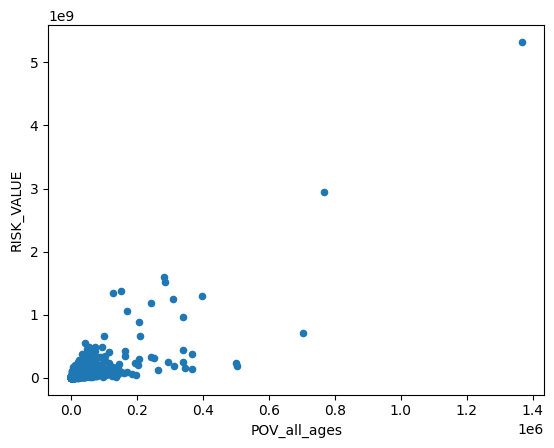

In [313]:
#Scatterplot of poverty in county and risk in county
pov_nri.plot.scatter(x="POV_all_ages", y="RISK_VALUE")


# Part 3: Visualizations and Machine Learning

The high correlation between poverty and risk proves our 2nd hypothesis correct, so we can proceed to visualizations and models. We will focus on heatmaps, an interactive map, and a machine learning regression model (including testing the number of variables that we should use to make our predictions more accurate).

In [314]:
#Saving copy for later
pov_nri2 = pov_nri.copy()

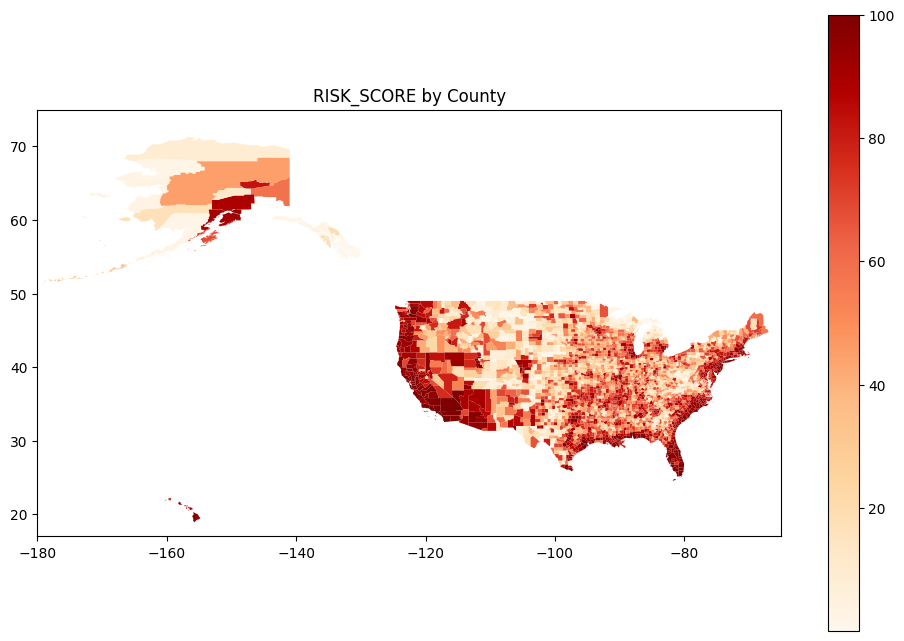

In [315]:
#Reading shapefile that dictates how counties are shaped on a map
gdf = gpd.read_file("cb_2018_us_county_500k.shp")

#Merging our dataframe and the empty geospatial viz
pov_nri.dropna()
merged = gdf.merge(pov_nri, on='GEOID', how='left')

col_name="RISK_SCORE"
#Plotting specifically data in a column (i chose risk_score just to test)
us = merged.plot(column=col_name, cmap='OrRd', legend=True, figsize=(12, 8))
title = col_name + ' by County'
plt.title(title)

#Set the extent to focus on the US
#Main part of US is [-130,-65]x[24,50]
us.set_xlim([-180, -65])  
us.set_ylim([17, 75])    

plt.show()

In [316]:
#Manually set the center and zoom level to cover the entire United States
center = [45, -135]
zoom_level = 3

#Create a Folium map centered around the entire United States
interactiveMap = folium.Map(location=center, zoom_start=zoom_level)

#Add a choropleth layer for risk
folium.Choropleth(
    geo_data=merged,
    data=merged,
    columns=["COUNTY", 'RISK_SCORE'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_weight=1,
    legend_name='Risk Level',
    nan_fill_color='gray',  #Gray places are NaN values
    nan_fill_opacity=0.4
).add_to(interactiveMap)

#Add GeoJson layer with hover information
folium.GeoJson(
    merged,
    style_function=lambda feature: {
        'fillColor': 'transparent',  #set fill color to transparent
        'color': 'transparent',  #set border color to transparent
        'weight': 0,  #set border weight to 0
        'dashArray': '5, 5',
        'fillOpacity': 0.7 
    },
    highlight_function=lambda x: {'fillColor': 'lightblue', 'color': 'lightblue'},
    tooltip=folium.features.GeoJsonTooltip( #example fields, will change this later
        fields=["GEOID", 'COUNTY', 'STATE', 'RISK_SCORE'],
        aliases=["GeoID", 'County', 'State', 'Risk Score'],
        localize=True
    )
).add_to(interactiveMap)

#Display the map
#interactiveMap


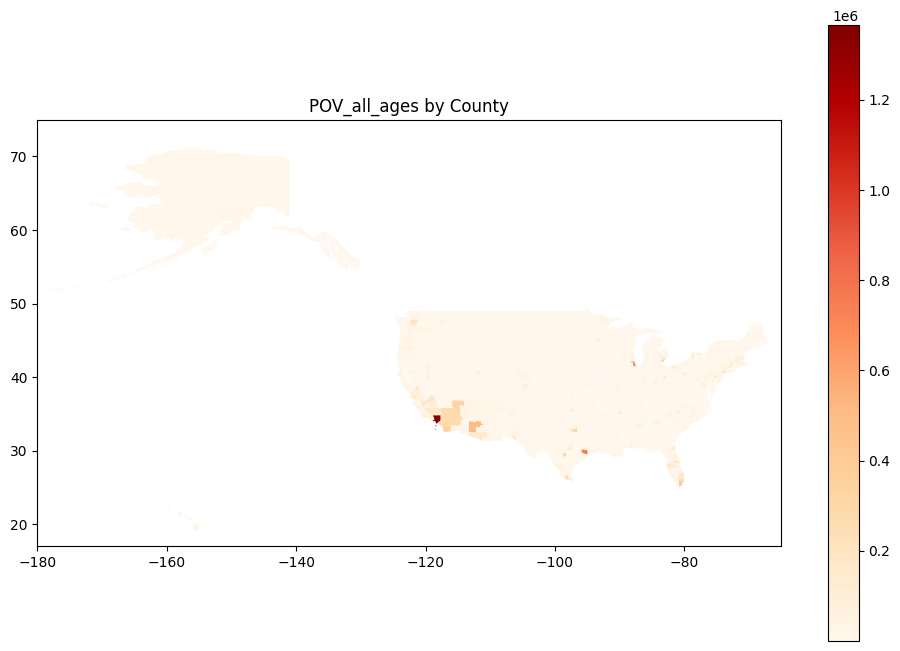

In [317]:
#Doing a heatmap of poverty results in not much 

merged = gdf.merge(pov_nri, on='GEOID', how='left')

col_name="POV_all_ages"
us = merged.plot(column=col_name, cmap='OrRd', legend=True, figsize=(12, 8))
title = col_name + ' by County'
plt.title(title)

us.set_xlim([-180, -65])  
us.set_ylim([17, 75])    

plt.show()

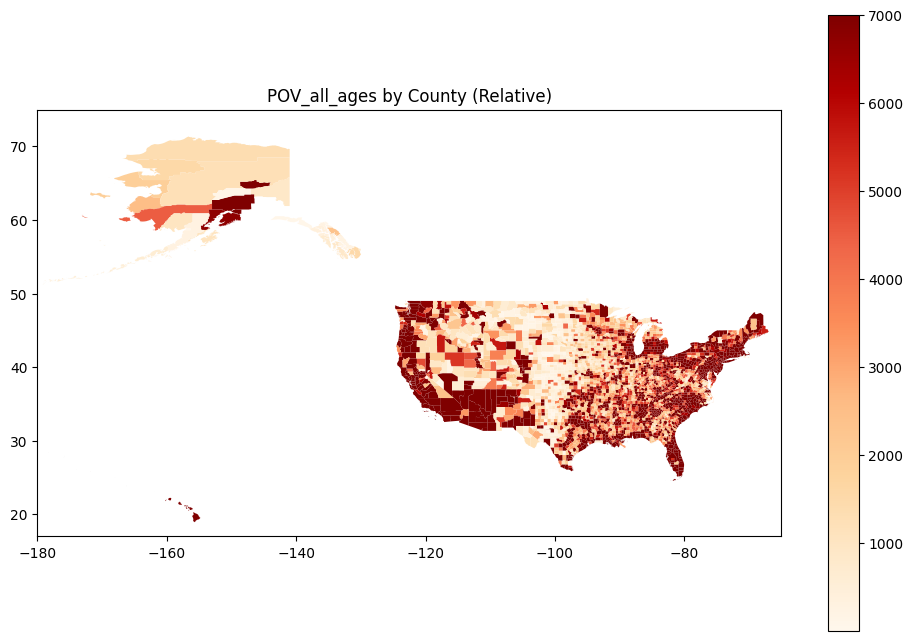

In [318]:
#Applying a max to see the relative poverty levels

pov_nri["POV_all_ages"] = pov_nri["POV_all_ages"].apply(lambda x: min(x, 7000))

merged = gdf.merge(pov_nri, on='GEOID', how='left')

col_name="POV_all_ages"
us = merged.plot(column=col_name, cmap='OrRd', legend=True, figsize=(12, 8))
title = col_name + ' by County (Relative)'
plt.title(title)

us.set_xlim([-180, -65])  
us.set_ylim([17, 75])    

plt.show()

In [319]:
#Creates a regression model based on these variables

#Need all non-NaN data for both 1-var and 2-var models
pov_nri2 = pov_nri2.dropna(subset=['POV_all_ages', 'POPULATION', 'RISK_VALUE'])

#Defining variables
x1 = pov_nri2[['POV_all_ages']]
y = pov_nri2['RISK_VALUE']

model = LinearRegression()
model.fit(x1, y)

LinearRegression()

In [320]:
#Working with a 2nd model to test if using another 
#We suspect this should increase the error
model2 = LinearRegression()
x2 = pov_nri2[['POV_all_ages', "POPULATION"]]
model2.fit(x2, y)

#Calculating absolute error (absolute value so that we don't get a mean of 0 since that is how RMSE works)
pov_nri2["pred1_error_abs"] = (((pov_nri2.RISK_VALUE - model.predict(x1)))).abs()
pov_nri2["pred2_error_abs"] = (((pov_nri2.RISK_VALUE - model2.predict(x2)))).abs()

#Printing error
print(f'Error 1: {pov_nri2["pred1_error_abs"].mean()}')
print(f'Error 2: {pov_nri2["pred2_error_abs"].mean()}')
#As shown, this does increase the error


Error 1: 22861280.405445743
Error 2: 24524357.26398039
